IMPORTING MODULES


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve,auc, confusion_matrix
from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED
from random import randint
from copy import deepcopy
import pickle

IMPORTING DATASET


In [ ]:
df = pd.read_csv('data_1.csv')

SPLITTING DATASET


In [ ]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
df_new = pd.read_csv('data_2.csv')

In [ ]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
!pip install -U scikit-multiflow

In [ ]:
from skmultiflow.data import SEAGenerator
from skmultiflow.trees import HoeffdingTreeClassifier

In [ ]:
ht = HoeffdingTreeClassifier()
stream = SEAGenerator(random_state=1)
ht.fit(X_train,y_train)

ht_new = deepcopy(ht)

ind = 0
for x in X_train_new:
  ht_new = ht_new.partial_fit([x],[y_train_new[ind]])
  ind+=1

In [ ]:
def compute_metrics(model,X_test,y_test):
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  print("Accuracy ",accuracy_score(y_test,y_pred))
  print("Precision ", precision_score(y_test,y_pred,average='micro'))
  print("Recall ",recall_score(y_test,y_pred,average='micro'))

  y_pred = label_binarize(y_pred,classes=[1,2,3])
  y_test_temp = label_binarize(y_test,classes = [1,2,3])
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(y_test_temp[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(3):
      plt.plot(fpr[i], tpr[i],label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))

  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC-ROC Curve')
  plt.legend()
  plt.show()

Accuracy  0.8724137931034482
Precision  0.8724137931034482
Recall  0.8724137931034482


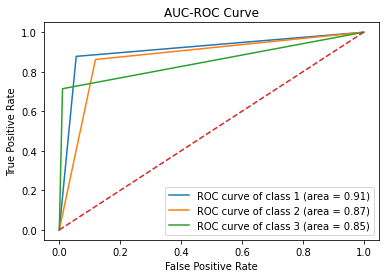

In [ ]:
compute_metrics(ht,X_test,y_test)

Accuracy  0.8758620689655172
Precision  0.8758620689655172
Recall  0.8758620689655172


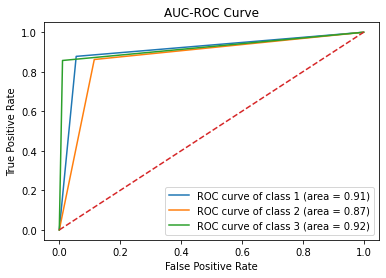

In [ ]:
compute_metrics(ht_new,X_test,y_test)

Accuracy  0.8724137931034482
Precision  0.8724137931034482
Recall  0.8724137931034482


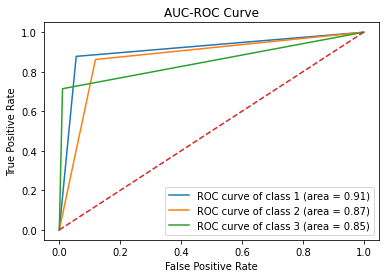

In [ ]:
compute_metrics(ht,X_test_new,y_test_new)

Accuracy  0.8758620689655172
Precision  0.8758620689655172
Recall  0.8758620689655172


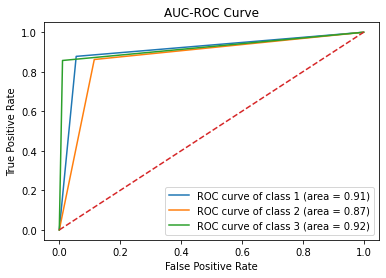

In [ ]:
compute_metrics(ht_new,X_test_new,y_test_new)

In [ ]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
y = label_binarize(y,classes=[1,2,3])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

Feature Scaling


In [ ]:
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree_new = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train,y_train)
decision_tree_new = deepcopy(decision_tree)

Augmenting new data

In [ ]:
df_new = pd.read_csv('data_2.csv')

Splitting new data

In [ ]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
y = label_binarize(y,classes=[1,2,3])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X,y,test_size=0.2,random_state=1)

Feature Scaling


In [ ]:
standard_scaler = StandardScaler()
X_train_new = standard_scaler.fit_transform(X_train_new)
X_test_new = standard_scaler.transform(X_test_new)

Distinct values of fatal health

In [ ]:
temp = set()
for i in df['fetal_health']:
  temp.add(i)

print(temp)

{1, 2, 3}


Tuning current Decision Tree According to data2

In [ ]:
temp = np.array([1,2,3])
temp = np.append(temp,[[4,5]])
print(temp,len(temp))
temp[2] = 4
print(temp[2])
print(len(X_train), len(X_train[0]), len(X_train_new), len(X_train_new[0]))

[1 2 3 4 5] 5
4
1160 21 1160 21


In [ ]:
def is_leaf(tree,index):
  return tree.children_right[index]==TREE_LEAF and tree.children_left[index]==TREE_LEAF

col = []
for i in df: col.append(i)
sz1 = len(X_train)
sz2 = len(X_train_new)
pred = decision_tree_new.predict(X_train_new)

def findgini(table):
  ans1 = 1
  sum1 = 0
  for i in range(3): sum1 += table[i][0]
  ans2 = 1
  sum2 = 0
  for i in range(3): sum2 += table[i][1]

  for i in range(3):
    if(sum1 != 0): ans1 -= (table[i][0]/sum1)**2
    if(sum2 != 0): ans2 -= (table[i][1]/sum2)**2
  
  if(sum1 + sum2 == 0): return 0
  return ans1 * (sum1/(sum1 + sum2)) + ans2 * (sum2/(sum1 + sum2))


def traverse_tree(tree, index, data1, data2, ans2):
  #leaf check
  if(is_leaf(tree,index)):
    return

  #finding the threshold
  currthreshold = tree.threshold[index]
  currfeature = tree.feature[index] - 1

  table = [[0,0],[0,0],[0,0]]
  for i in range(len(data1)):
    table[int(data1[i][-1]) - 1][0 if (data1[i][currfeature] < tree.threshold[index]) else 1] +=1

  sens = table[0][0]/(table[0][0] + table[1][0] + table[2][0] + 0.00001)
  spec = table[2][0]/(table[0][0] + table[1][0] + table[2][0] + 0.000001)
  m = (table[0][1] - table[2][0])/(table[2][1] - table[0][0] + 0.0000001)

  tree.threshold[index] = sens - m * (1 - spec) + currthreshold
  # print((sens - m * (1 - spec)))

  ginival = findgini(table)
  tree.impurity[index] = ginival

  # distributing data according to the split.
  leftdata1 = []
  rightdata1 = []
  for i in range(len(data1)):
    if(data1[i][currfeature] < tree.threshold[index]): leftdata1.append(data1[i])
    else: rightdata1.append(data1[i])

  # if(tree.threshold[index] > currthreshold + 5): tree.threshold[index] = currthreshold + 5
  # elif(tree.threshold[index] < currthreshold - 5): tree.threshold[index] = currthreshold - 5
  
  newansleft = []
  newansright = []
  leftdata2 = []
  rightdata2 = []
  for i in range(len(data2)):
    if(data2[i][currfeature] < tree.threshold[index]):
       leftdata2.append(data2[i])
       newansleft.append(ans2[i])
    else: 
      rightdata2.append(data2[i])
      newansright.append(ans2[i])

  # print(currfeature,remaining_feature)
  # new_feature.remove(currfeature)
  # tree.value[index] = table/

  if(leftdata2 != []): traverse_tree(tree, tree.children_left[index], leftdata1, leftdata2, newansleft)
  # else: tree.children_left[index] = TREE_LEAF #pruning
  if(rightdata2 != []): traverse_tree(tree, tree.children_right[index], rightdata1, rightdata2, newansright)
  # else: tree.children_right[index] = TREE_LEAF #pruning


remaining_feature = []
for i in range(len(X_train[0]) - 1): remaining_feature.append(i)
data1 = deepcopy(X_train)
data2 = deepcopy(X_train_new)
ans = deepcopy(y_train_new)

traverse_tree(decision_tree_new.tree_,0,data1,data2, ans)


Curve for testset of data1

Accuracy  0.9413793103448276
Precision  0.9413793103448276
Recall  0.9413793103448276


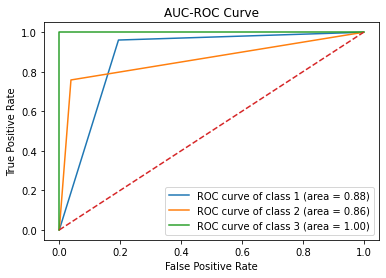

In [ ]:
compute_metrics(decision_tree,X_test,y_test)

Accuracy  0.9241379310344827
Precision  0.9241379310344827
Recall  0.9241379310344827


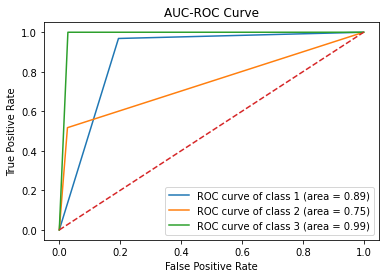

In [ ]:
compute_metrics(decision_tree_new,X_test,y_test)

Curve for testset of data2

Accuracy  0.9413793103448276
Precision  0.9413793103448276
Recall  0.9413793103448276


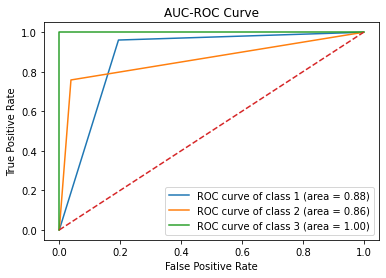

In [ ]:
compute_metrics(decision_tree,X_test_new,y_test_new)

Accuracy  0.9241379310344827
Precision  0.9241379310344827
Recall  0.9241379310344827


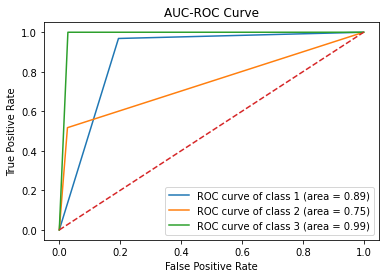

In [ ]:
compute_metrics(decision_tree_new,X_test_new,y_test_new)

# Save model to a file

In [ ]:
filename = "DT_C_2.pkl"
with open(filename, 'wb') as file:  
    pickle.dump(decision_tree_new, file)

In [ ]:
filename = "DT_C_1.pkl"
with open(filename, 'wb') as file:  
    pickle.dump(ht_new, file)